In [2]:
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup

base_url = "http://dfoh.uclouvain.be/database/cases/"
dfoh_cases = "/home/savymik/Pictures/dfoh_cases"
os.makedirs(dfoh_cases, exist_ok=True)

def get_filelink():
    response = requests.get(base_url)
    if response.status_code != 200:
        raise Exception(f"Failed!, status code {response.status_code}")
    soup = BeautifulSoup(response.text, 'html.parser')
    links = [a['href'] for a in soup.find_all('a', href=True)]
    valid_cases = [link for link in links if link and not link.endswith('.tmp') and '/cases/' in link]
    valid_cases = [base_url + link.split("/cases/")[-1] for link in valid_cases]
    return valid_cases
  
def cases_downloads():
    cases_links = get_filelink()
    for case_url in cases_links:
        fname = case_url.split("/")[-1]
        fpath = os.path.join(dfoh_cases, fname)
        if os.path.exists(fpath):
            print(f"File exists! Skipping: {fname}")
            continue
        # print(f"Downloading: {fname}")
        response = requests.get(case_url, stream=True)
        if response.status_code == 200:
            with open(fpath, 'wb') as f:
                for chunk in response.iter_content(1024):
                    f.write(chunk)
            # print(f"Downloaded: {fname}")
        else:
            print(f"Failed to download {case_url}, status code {response.status_code}")

def parse_dfoh_cases():
    for fname in os.listdir(dfoh_cases):
        fpath = os.path.join(dfoh_cases, fname)
        if not os.path.isfile(fpath):
            continue
        # print(f"Processing: {fname}")
        df = parse_dfoh_file(fpath)
        if df.empty:
            print(f"No valid data extracted for: {fname}, skip saving!")
            continue
        csv_fname = os.path.join(dfoh_cases, fname + ".csv")
        df.to_csv(csv_fname, index=False)
        # print(f"Saved: {csv_fname}")

def parse_dfoh_file(fpath):
    if not os.path.exists(fpath):
        print(f"File does not exist: {fpath}, skip parsing!")
        return pd.DataFrame()
    date = os.path.basename(fpath)[:10]
    cases = []
    with open(fpath, 'r') as f:
        lines = f.readlines()
    status = None
    attacker = None
    victim = None
    additional_attributes = {}
    
    for line in lines:
        parts = line.strip().split()
        if not parts:
            continue 
        if line.startswith("!leg") or line.startswith("!sus"):
            status = "leg" if line.startswith("!leg") else "sus"
            if len(parts) < 6:
                print(f"Incomplete line: {line.strip()}, skipping!")
                continue
            attacker, victim = parts[1], parts[2]
            leg_count, sus_count, path_count = map(int, parts[3:6])
            metadata_parts = line.split("attackers:")[-1].strip().split(";")
            additional_attributes = {k: v for k, v in (x.split(":") for x in metadata_parts if ":" in x)}
        else:
            if len(parts) < 5:
                print(f"Incomplete inference line: {line.strip()}, skipping!")
                continue
            try:
                inference_id, leg_flag, sus_flag = map(int, parts[2:5])
            except ValueError:
                print(f"Non-int inference line: {line.strip()}, skipping!")
                continue
            cases.append({"date": date,"status": status,"attacker": attacker,"victim": victim,"leg_infrence_cnts": leg_count,"sus_infrence_cnts": sus_count,
                            "path_cnts": path_count,"type": additional_attributes.get("type", "unknown"),"valid_origin": additional_attributes.get("valid_origin", "unknown"),
                            "recurrent": additional_attributes.get("recurrent", "unknown"),"local": additional_attributes.get("local", "unknown"),"inference_id": inference_id,"leg_flag": leg_flag,"sus_flag": sus_flag
                            })
    return pd.DataFrame(cases)

def main():
    cases_downloads()
    parse_dfoh_cases()

if __name__ == "__main__":
    main()


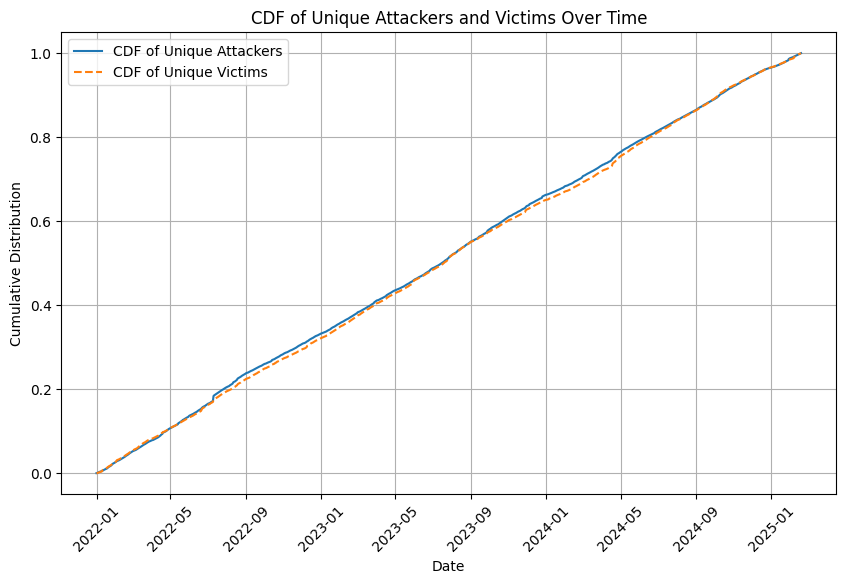

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the directory containing the CSV files
data_directory = "/home/savymik/Pictures/dfoh_cases"

# List all CSV files in the directory
csv_files = [os.path.join(data_directory, file) for file in os.listdir(data_directory) if file.endswith(".csv")]

# Read and concatenate all CSV files
df_list = [pd.read_csv(file) for file in csv_files]
df = pd.concat(df_list, ignore_index=True)

# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Group by date and count unique attackers and victims
cdf_data = df.groupby('date').agg(
    unique_attackers=('attacker', lambda x: x.nunique()),
    unique_victims=('victim', lambda x: x.nunique())
).reset_index()

# Compute the cumulative sum to get the CDF
cdf_data['cumulative_attackers'] = cdf_data['unique_attackers'].cumsum()
cdf_data['cumulative_victims'] = cdf_data['unique_victims'].cumsum()

# Normalize to get CDF values between 0 and 1
cdf_data['cdf_attackers'] = cdf_data['cumulative_attackers'] / cdf_data['cumulative_attackers'].iloc[-1]
cdf_data['cdf_victims'] = cdf_data['cumulative_victims'] / cdf_data['cumulative_victims'].iloc[-1]

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(cdf_data['date'], cdf_data['cdf_attackers'], label="CDF of Unique Attackers")
plt.plot(cdf_data['date'], cdf_data['cdf_victims'], label="CDF of Unique Victims", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Cumulative Distribution")
plt.title("CDF of Unique Attackers and Victims Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


Numerical summary saved to cdf_unique_attackers_victims.csv


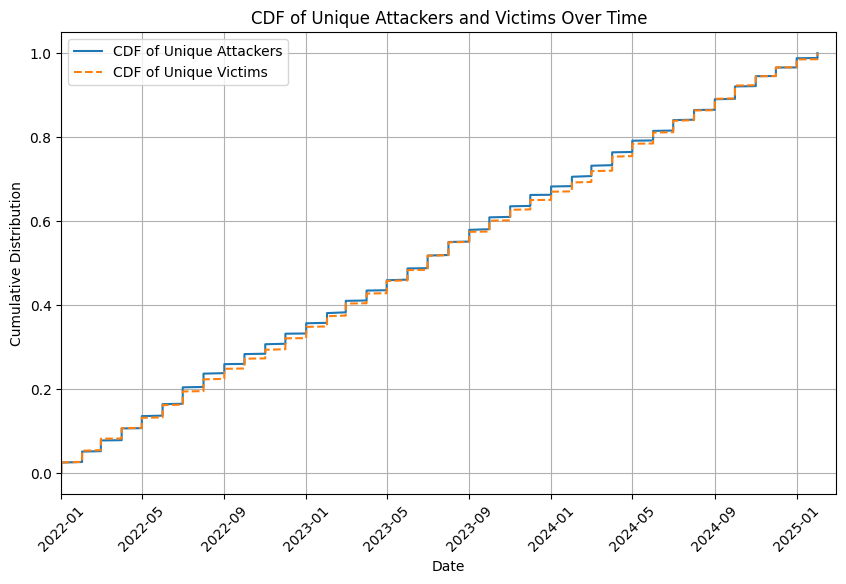

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the directory containing the CSV files
data_directory = "/home/savymik/Pictures/dfoh_cases"

# List all CSV files in the directory
csv_files = [os.path.join(data_directory, file) for file in os.listdir(data_directory) if file.endswith(".csv")]

# Read and concatenate all CSV files
df_list = [pd.read_csv(file) for file in csv_files]
df = pd.concat(df_list, ignore_index=True)

# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Group by date and count unique attackers and victims
cdf_data = df.groupby('date').agg(
    unique_attackers=('attacker', lambda x: x.nunique()),
    unique_victims=('victim', lambda x: x.nunique())
).reset_index()

# Compute the cumulative sum to get the CDF
cdf_data['cumulative_attackers'] = cdf_data['unique_attackers'].cumsum()
cdf_data['cumulative_victims'] = cdf_data['unique_victims'].cumsum()

# Normalize to get CDF values between 0 and 1
cdf_data['cdf_attackers'] = cdf_data['cumulative_attackers'] / cdf_data['cumulative_attackers'].iloc[-1]
cdf_data['cdf_victims'] = cdf_data['cumulative_victims'] / cdf_data['cumulative_victims'].iloc[-1]

# Format the date column as "Mon-Year"
cdf_data['date'] = cdf_data['date'].dt.strftime('%b-%Y')

# Save the numerical summary to a CSV file
csv_filename = "cdf_unique_attackers_victims.csv"
cdf_data.to_csv(csv_filename, index=False)

print(f"Numerical summary saved to {csv_filename}")

# Convert date column back to datetime for plotting
cdf_data['date'] = pd.to_datetime(cdf_data['date'], format='%b-%Y')

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(cdf_data['date'], cdf_data['cdf_attackers'], label="CDF of Unique Attackers")
plt.plot(cdf_data['date'], cdf_data['cdf_victims'], label="CDF of Unique Victims", linestyle="dashed")

# Set x-axis limits
plt.xlim(pd.to_datetime("2022-01-01"), pd.to_datetime("2025-03-01"))

plt.xlabel("Date")
plt.ylabel("Cumulative Distribution")
plt.title("CDF of Unique Attackers and Victims Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


Numerical summary saved to cdf_unique_attackers_victims.csv


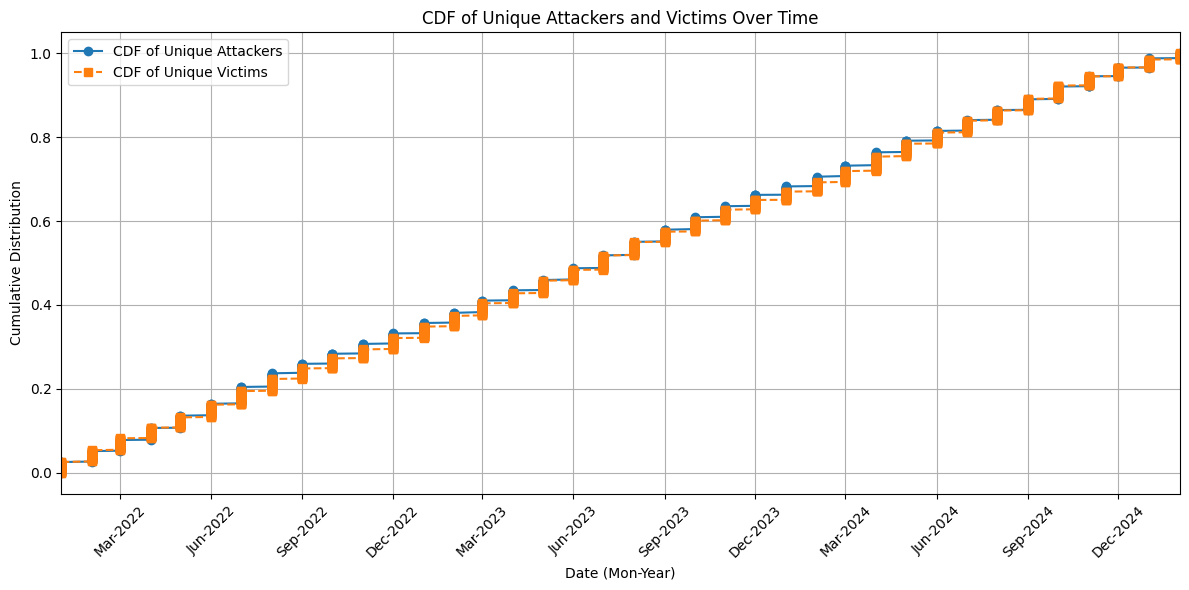

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define the directory containing the CSV files
data_directory = "/home/savymik/Pictures/dfoh_cases"

# Check if the directory exists and has CSV files
if not os.path.exists(data_directory):
    raise FileNotFoundError(f"Directory '{data_directory}' does not exist.")
    
csv_files = [os.path.join(data_directory, file) for file in os.listdir(data_directory) if file.endswith(".csv")]

if not csv_files:
    raise FileNotFoundError("No CSV files found in the directory.")

# Read and concatenate all CSV files
df_list = [pd.read_csv(file) for file in csv_files]
df = pd.concat(df_list, ignore_index=True)

# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Handle potential parsing errors

# Drop any rows where date conversion failed
df = df.dropna(subset=['date'])

# Group by date and count unique attackers and victims
cdf_data = df.groupby('date').agg(
    unique_attackers=('attacker', lambda x: x.nunique()),
    unique_victims=('victim', lambda x: x.nunique())
).reset_index()

# Compute the cumulative sum to get the CDF
cdf_data['cumulative_attackers'] = cdf_data['unique_attackers'].cumsum()
cdf_data['cumulative_victims'] = cdf_data['unique_victims'].cumsum()

# Normalize to get CDF values between 0 and 1
cdf_data['cdf_attackers'] = cdf_data['cumulative_attackers'] / cdf_data['cumulative_attackers'].iloc[-1]
cdf_data['cdf_victims'] = cdf_data['cumulative_victims'] / cdf_data['cumulative_victims'].iloc[-1]

# Format the date column as "Mon-Year"
cdf_data['formatted_date'] = cdf_data['date'].dt.strftime('%b-%Y')

# Save the numerical summary to a CSV file
csv_filename = "cdf_unique_attackers_victims.csv"
cdf_data.to_csv(csv_filename, index=False)
print(f"Numerical summary saved to {csv_filename}")

# Convert date column back to datetime for plotting
cdf_data['date'] = pd.to_datetime(cdf_data['formatted_date'], format='%b-%Y')

# Plot the CDF
plt.figure(figsize=(12, 6))
plt.plot(cdf_data['date'], cdf_data['cdf_attackers'], label="CDF of Unique Attackers", marker='o')
plt.plot(cdf_data['date'], cdf_data['cdf_victims'], label="CDF of Unique Victims", linestyle="dashed", marker='s')

# Set x-axis format to Mon-Year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months

# Set x-axis limits dynamically based on the data range
plt.xlim([cdf_data['date'].min(), cdf_data['date'].max()])

plt.xlabel("Date (Mon-Year)")
plt.ylabel("Cumulative Distribution")
plt.title("CDF of Unique Attackers and Victims Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Numerical summary saved to cdf_unique_attackers_victims.csv


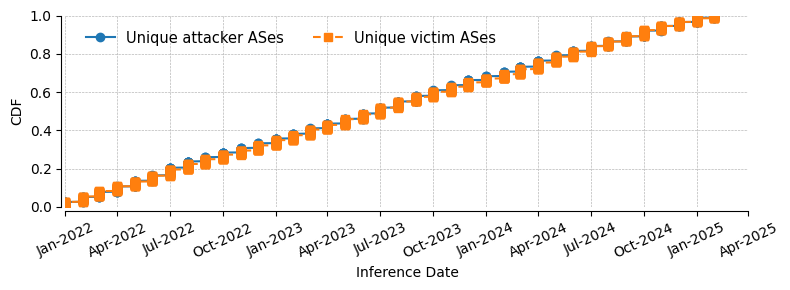

In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define the directory containing the CSV files
data_directory = "/home/savymik/Pictures/dfoh_cases"

# Check if the directory exists and has CSV files
if not os.path.exists(data_directory):
    raise FileNotFoundError(f"Directory '{data_directory}' does not exist.")
    
csv_files = [os.path.join(data_directory, file) for file in os.listdir(data_directory) if file.endswith(".csv")]

if not csv_files:
    raise FileNotFoundError("No CSV files found in the directory.")

# Read and concatenate all CSV files
df_list = [pd.read_csv(file) for file in csv_files]
df = pd.concat(df_list, ignore_index=True)

# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Handle potential parsing errors

# Drop any rows where date conversion failed
df = df.dropna(subset=['date'])

# Group by date and count unique attackers and victims
cdf_data = df.groupby('date').agg(
    unique_attackers=('attacker', lambda x: x.nunique()),
    unique_victims=('victim', lambda x: x.nunique())
).reset_index()

# Compute the cumulative sum to get the CDF
cdf_data['cumulative_attackers'] = cdf_data['unique_attackers'].cumsum()
cdf_data['cumulative_victims'] = cdf_data['unique_victims'].cumsum()

# Normalize to get CDF values between 0 and 1
cdf_data['cdf_attackers'] = cdf_data['cumulative_attackers'] / cdf_data['cumulative_attackers'].iloc[-1]
cdf_data['cdf_victims'] = cdf_data['cumulative_victims'] / cdf_data['cumulative_victims'].iloc[-1]

# Format the date column as "Mon-Year"
cdf_data['formatted_date'] = cdf_data['date'].dt.strftime('%b-%Y')

# Save the numerical summary to a CSV file
csv_filename = "cdf_unique_attackers_victims.csv"
cdf_data.to_csv(csv_filename, index=False)
print(f"Numerical summary saved to {csv_filename}")

# Convert date column back to datetime for plotting
cdf_data['date'] = pd.to_datetime(cdf_data['formatted_date'], format='%b-%Y')

# Define explicit x-axis limits
start_date = pd.to_datetime("2022-01-01")
end_date = pd.to_datetime("2025-04-01")

# Plot the CDF
plt.figure(figsize=(8, 3))
plt.plot(cdf_data['date'], cdf_data['cdf_attackers'], label="Unique attacker ASes", marker='o')
plt.plot(cdf_data['date'], cdf_data['cdf_victims'], label="Unique victim ASes", linestyle="dashed", marker='s')

# Set x-axis format to Mon-Year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months

# Explicitly set x-axis limits
plt.xlim([start_date, end_date])

plt.xlabel("Inference Date")
plt.ylabel("CDF")
# plt.title("CDF of Unique Attackers and Victims Over Time")
plt.legend(loc="upper right", bbox_to_anchor=(0.65, 0.99), ncol=2, frameon=False, fontsize=10.5)
plt.grid(linestyle='--', linewidth=0.45)
plt.ylim(0, 1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_position(('outward', 3))
plt.gca().spines['bottom'].set_position(('outward', 3))
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()


Numerical summary saved to cdf_unique_attackers_victims.csv


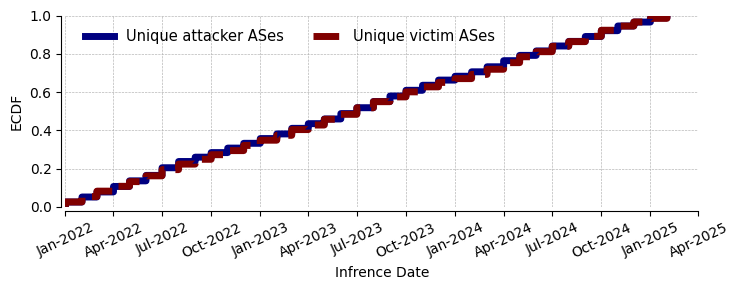

In [176]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define the directory containing the CSV files
data_directory = "/home/savymik/Pictures/dfoh_cases"

# Check if the directory exists and has CSV files
if not os.path.exists(data_directory):
    raise FileNotFoundError(f"Directory '{data_directory}' does not exist.")
    
csv_files = [os.path.join(data_directory, file) for file in os.listdir(data_directory) if file.endswith(".csv")]

if not csv_files:
    raise FileNotFoundError("No CSV files found in the directory.")

# Read and concatenate all CSV files
df_list = [pd.read_csv(file) for file in csv_files]
df = pd.concat(df_list, ignore_index=True)

# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Handle potential parsing errors
df = df.dropna(subset=['date'])  # Drop rows where date conversion failed

# Group by date and count unique attackers and victims
cdf_data = df.groupby('date').agg(
    unique_attackers=('attacker', lambda x: x.nunique()),
    unique_victims=('victim', lambda x: x.nunique())
).reset_index()

# Format the date column as "Mon-Year"
cdf_data['formatted_date'] = cdf_data['date'].dt.strftime('%b-%Y')

# Save the numerical summary to a CSV file
csv_filename = "cdf_unique_attackers_victims.csv"
cdf_data.to_csv(csv_filename, index=False)
print(f"Numerical summary saved to {csv_filename}")

# Convert date column back to datetime for plotting
cdf_data['date'] = pd.to_datetime(cdf_data['formatted_date'], format='%b-%Y')

# Define explicit x-axis limits
start_date = pd.to_datetime("2022-01-01")
end_date = pd.to_datetime("2025-04-01")

# Plot the seaborn eCDF
plt.figure(figsize=(7.5, 3))
sns.ecdfplot(data=cdf_data, x='date', weights='unique_attackers', color='navy', linewidth=5, label="Unique attacker ASes")
sns.ecdfplot(data=cdf_data, x='date', weights='unique_victims', color='maroon', linewidth=5, label="Unique victim ASes", linestyle="dashed")

# Set x-axis format to Mon-Year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months

# Explicitly set x-axis limits
plt.xlim([start_date, end_date])

plt.xlabel("Infrence Date")
plt.ylabel("ECDF")
plt.legend(loc="upper right", bbox_to_anchor=(0.70, 1), ncol=2, frameon=False, fontsize=10.5)
plt.grid(linestyle='--', linewidth=0.45)
plt.ylim(0, 1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_position(('outward', 3))
plt.gca().spines['bottom'].set_position(('outward', 3))
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()


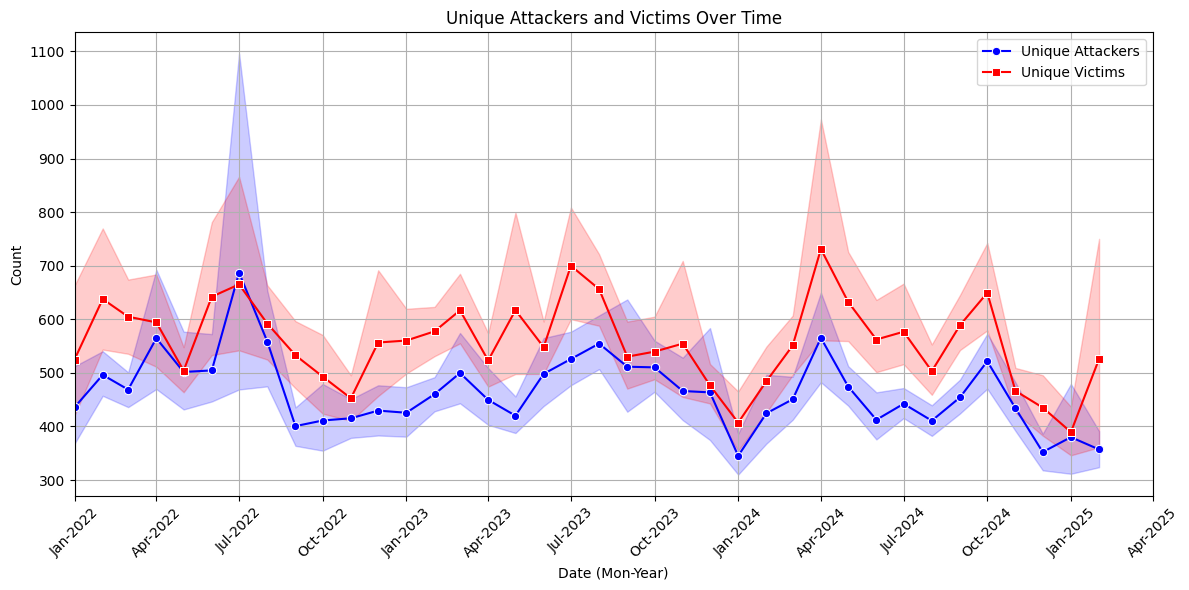

In [177]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=cdf_data, x='date', y='unique_attackers', marker='o', label="Unique Attackers", color='blue')
sns.lineplot(data=cdf_data, x='date', y='unique_victims', marker='s', label="Unique Victims", color='red')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  
plt.xlim([start_date, end_date])

plt.xlabel("Date (Mon-Year)")
plt.ylabel("Count")
plt.title("Unique Attackers and Victims Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


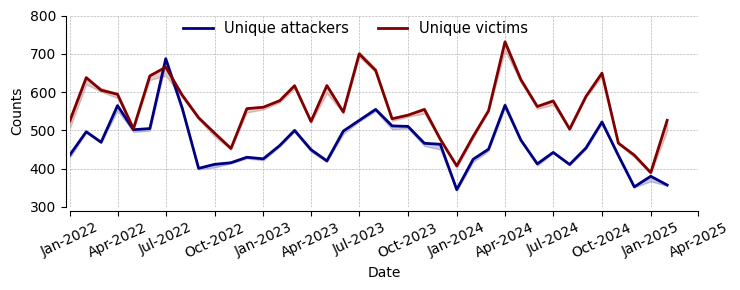

In [206]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Ensure data is sorted
cdf_data = cdf_data.sort_values(by="date")

plt.figure(figsize=(7.5, 3))

# Plot the raw daily data instead of monthly aggregates
sns.lineplot(data=cdf_data, x='date', y='unique_attackers',linewidth=2,  label="Unique attackers", color='navy', errorbar=('ci', 10))
sns.lineplot(data=cdf_data, x='date', y='unique_victims',linewidth=2,  label="Unique victims", color='maroon', errorbar=('ci', 10))

# Ensure daily granularity and avoid smoothing
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every month

plt.xlabel("Date")
plt.ylabel("Counts")
# plt.title("Unique Attackers and Victims Over Time (Daily Data)")
start_date = pd.to_datetime("2022-01-01")
end_date = pd.to_datetime("2025-04-01")
plt.legend()
plt.grid(True)
plt.xlim([start_date, end_date])

plt.legend(loc="upper right", bbox_to_anchor=(0.75, 1.04), ncol=2, frameon=False, fontsize=10.5)
plt.grid(linestyle='--', linewidth=0.45)
plt.ylim(300, 800)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_position(('outward', 3))
plt.gca().spines['bottom'].set_position(('outward', 3))
plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig("/home/savymik/cnsm/cnsm-submission/figures/unique_attackers_victims_daily.png", dpi=300)
plt.show()


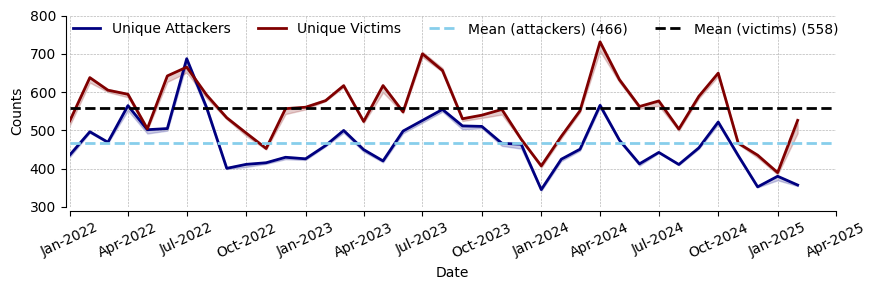

In [199]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Compute the mean values
mean_attackers = cdf_data['unique_attackers'].mean()
mean_victims = cdf_data['unique_victims'].mean()

# Create figure
plt.figure(figsize=(9, 3))

# Plot line graphs
sns.lineplot(data=cdf_data, x='date', y='unique_attackers', label="Unique Attackers", color='navy', errorbar=('ci', 10), linewidth=2)
sns.lineplot(data=cdf_data, x='date', y='unique_victims', label="Unique Victims", color='maroon', errorbar=('ci', 10), linewidth=2)

# Add horizontal mean lines
plt.axhline(mean_attackers, color='skyblue', linestyle='dashed', linewidth=2, label=f"Mean (attackers) ({mean_attackers:.0f})")
plt.axhline(mean_victims, color='black', linestyle='dashed', linewidth=2, label=f"Mean (victims) ({mean_victims:.0f})")

# Format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  
plt.xlim([cdf_data['date'].min(), cdf_data['date'].max()])

# Labels and title
plt.xlabel("Date")
plt.ylabel("Counts")
start_date = pd.to_datetime("2022-01-01")
end_date = pd.to_datetime("2025-04-01")
plt.legend()
plt.grid(True)
plt.xlim([start_date, end_date])

plt.legend(loc="upper right", bbox_to_anchor=(1.020, 1.03), ncol=4, frameon=False, fontsize=10)
plt.grid(linestyle='--', linewidth=0.45)
plt.ylim(300, 800)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_position(('outward', 3))
plt.gca().spines['bottom'].set_position(('outward', 3))
plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig("/home/savymik/cnsm/cnsm-submission/figures/unique_attackers_victims_daily.average.png", dpi=300)

# Show the plot
plt.show()


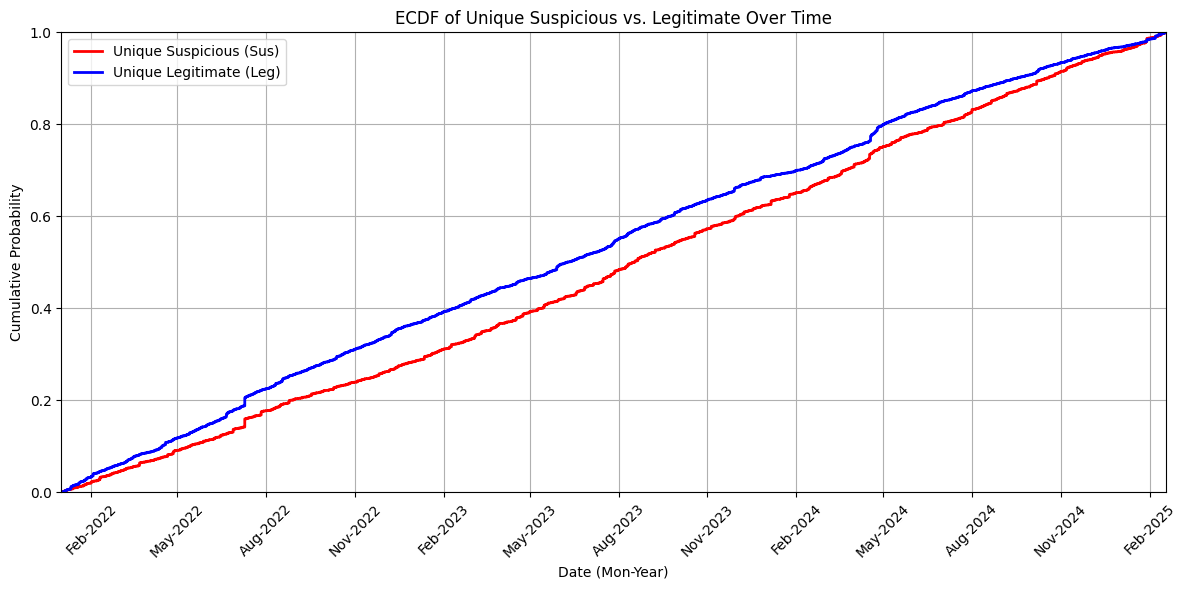

In [145]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Define the directory containing the CSV files
data_directory = "/home/savymik/Pictures/dfoh_cases"

# List all CSV files in the directory
csv_files = [os.path.join(data_directory, file) for file in os.listdir(data_directory) if file.endswith(".csv")]

# Read and concatenate all CSV files into a single DataFrame
df_list = [pd.read_csv(file) for file in csv_files]
cdf_data = pd.concat(df_list, ignore_index=True)

# Convert 'date' column to datetime format
cdf_data['date'] = pd.to_datetime(cdf_data['date'], errors='coerce')

# Drop NaN dates (if any exist due to parsing errors)
cdf_data = cdf_data.dropna(subset=['date'])

# Remove redundant "sus" and "leg" values per attacker or victim
unique_sus = cdf_data[cdf_data['status'] == 'sus'].drop_duplicates(subset=['attacker', 'victim'])
unique_leg = cdf_data[cdf_data['status'] == 'leg'].drop_duplicates(subset=['attacker', 'victim'])

# Create ECDF plot for unique "sus" (suspicious) and "leg" (legitimate)
plt.figure(figsize=(12, 6))
sns.ecdfplot(data=unique_sus, x='date', label="Unique Suspicious (Sus)", color='red', linewidth=2)
sns.ecdfplot(data=unique_leg, x='date', label="Unique Legitimate (Leg)", color='blue', linewidth=2)

# Format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xlim([cdf_data['date'].min(), cdf_data['date'].max()])

# Labels and title
plt.xlabel("Date (Mon-Year)")
plt.ylabel("Cumulative Probability")
plt.title("ECDF of Unique Suspicious vs. Legitimate Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

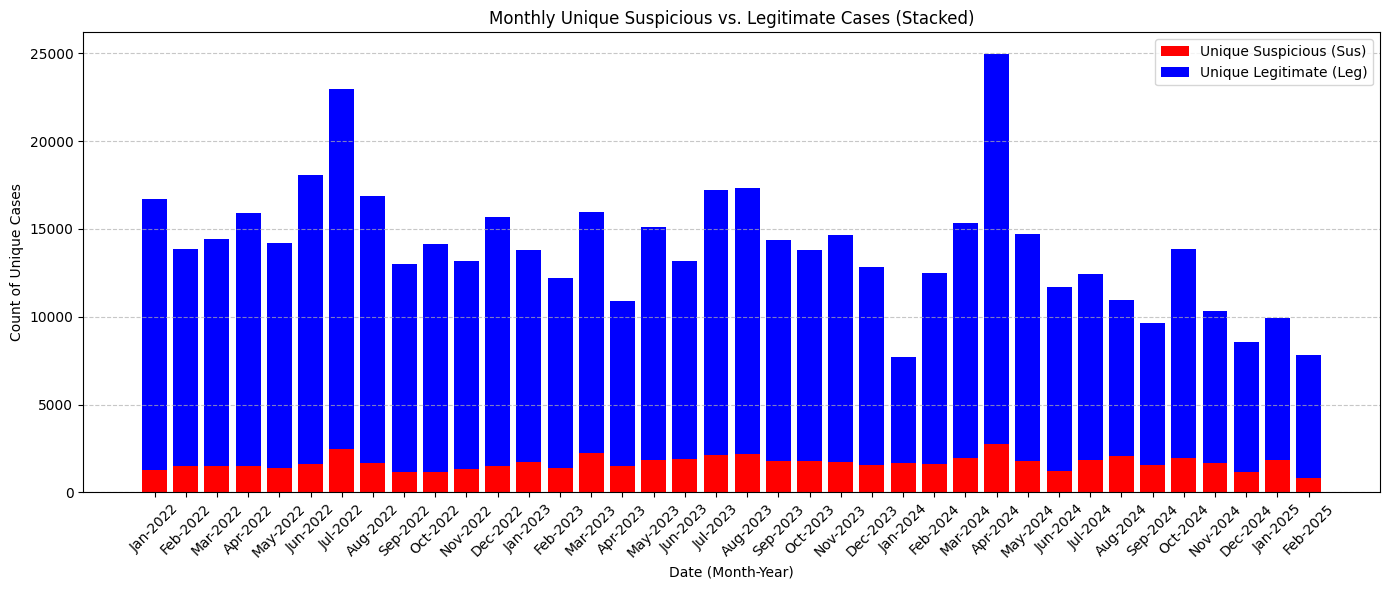

In [151]:


import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the directory containing the CSV files
data_directory = "/home/savymik/Pictures/dfoh_cases"

# List all CSV files in the directory
csv_files = [os.path.join(data_directory, file) for file in os.listdir(data_directory) if file.endswith(".csv")]

# Read and concatenate all CSV files into a single DataFrame
df_list = [pd.read_csv(file) for file in csv_files]
cdf_data = pd.concat(df_list, ignore_index=True)

# Convert 'date' column to datetime format
cdf_data['date'] = pd.to_datetime(cdf_data['date'], errors='coerce')

# Drop NaN dates (if any exist due to parsing errors)
cdf_data = cdf_data.dropna(subset=['date'])

# Remove redundant "sus" and "leg" values per attacker or victim
unique_sus = cdf_data[cdf_data['status'] == 'sus'].drop_duplicates(subset=['attacker', 'victim'])
unique_leg = cdf_data[cdf_data['status'] == 'leg'].drop_duplicates(subset=['attacker', 'victim'])

# Extract "Month-Year" for aggregation
unique_sus['month_year'] = unique_sus['date'].dt.strftime('%Y-%m')
unique_leg['month_year'] = unique_leg['date'].dt.strftime('%Y-%m')

# Count unique occurrences per month
sus_counts = unique_sus.groupby('month_year').size().reset_index(name='unique_sus')
leg_counts = unique_leg.groupby('month_year').size().reset_index(name='unique_leg')

# Merge both counts into one DataFrame for plotting
monthly_counts = pd.merge(sus_counts, leg_counts, on='month_year', how='outer').fillna(0)

# Sort by date to ensure bars are in chronological order
monthly_counts['month_year'] = pd.to_datetime(monthly_counts['month_year'], format='%Y-%m')
monthly_counts = monthly_counts.sort_values('month_year')

# Convert back to string for x-axis labels
monthly_counts['month_year'] = monthly_counts['month_year'].dt.strftime('%b-%Y')

# Plot stacked bar chart
plt.figure(figsize=(14, 6))
plt.bar(monthly_counts['month_year'], monthly_counts['unique_sus'], color='red', label="Unique Suspicious (Sus)")
plt.bar(monthly_counts['month_year'], monthly_counts['unique_leg'], bottom=monthly_counts['unique_sus'], color='blue', label="Unique Legitimate (Leg)")

# Labels and title
plt.xlabel("Date (Month-Year)")
plt.ylabel("Count of Unique Cases")
plt.title("Monthly Unique Suspicious vs. Legitimate Cases (Stacked)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


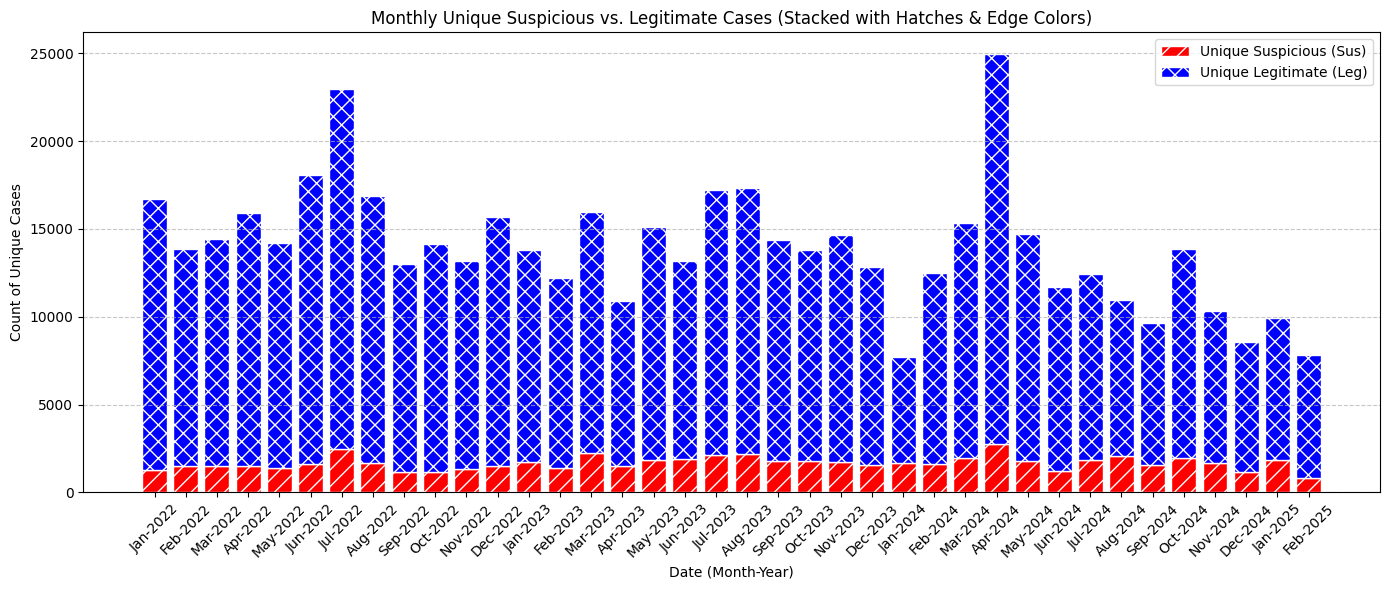

In [154]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the directory containing the CSV files
data_directory = "/home/savymik/Pictures/dfoh_cases"

# List all CSV files in the directory
csv_files = [os.path.join(data_directory, file) for file in os.listdir(data_directory) if file.endswith(".csv")]

# Read and concatenate all CSV files into a single DataFrame
df_list = [pd.read_csv(file) for file in csv_files]
cdf_data = pd.concat(df_list, ignore_index=True)

# Convert 'date' column to datetime format
cdf_data['date'] = pd.to_datetime(cdf_data['date'], errors='coerce')

# Drop NaN dates (if any exist due to parsing errors)
cdf_data = cdf_data.dropna(subset=['date'])

# Remove redundant "sus" and "leg" values per attacker or victim
unique_sus = cdf_data[cdf_data['status'] == 'sus'].drop_duplicates(subset=['attacker', 'victim'])
unique_leg = cdf_data[cdf_data['status'] == 'leg'].drop_duplicates(subset=['attacker', 'victim'])

# Extract "Month-Year" for aggregation
unique_sus['month_year'] = unique_sus['date'].dt.strftime('%Y-%m')
unique_leg['month_year'] = unique_leg['date'].dt.strftime('%Y-%m')

# Count unique occurrences per month
sus_counts = unique_sus.groupby('month_year').size().reset_index(name='unique_sus')
leg_counts = unique_leg.groupby('month_year').size().reset_index(name='unique_leg')

# Merge both counts into one DataFrame for plotting
monthly_counts = pd.merge(sus_counts, leg_counts, on='month_year', how='outer').fillna(0)

# Sort by date to ensure bars are in chronological order
monthly_counts['month_year'] = pd.to_datetime(monthly_counts['month_year'], format='%Y-%m')
monthly_counts = monthly_counts.sort_values('month_year')

# Convert back to string for x-axis labels
monthly_counts['month_year'] = monthly_counts['month_year'].dt.strftime('%b-%Y')

# Plot stacked bar chart with hatches and edge colors
plt.figure(figsize=(14, 6))

bars1 = plt.bar(
    monthly_counts['month_year'],
    monthly_counts['unique_sus'],
    color='red',
    label="Unique Suspicious (Sus)",
    hatch='//',  # Diagonal stripes
    edgecolor='white'
)

bars2 = plt.bar(
    monthly_counts['month_year'],
    monthly_counts['unique_leg'],
    bottom=monthly_counts['unique_sus'],
    color='blue',
    label="Unique Legitimate (Leg)",
    hatch='xx',  # Cross-hatch pattern
    edgecolor='white'
)

# Labels and title
plt.xlabel("Date (Month-Year)")
plt.ylabel("Count of Unique Cases")
plt.title("Monthly Unique Suspicious vs. Legitimate Cases (Stacked with Hatches & Edge Colors)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


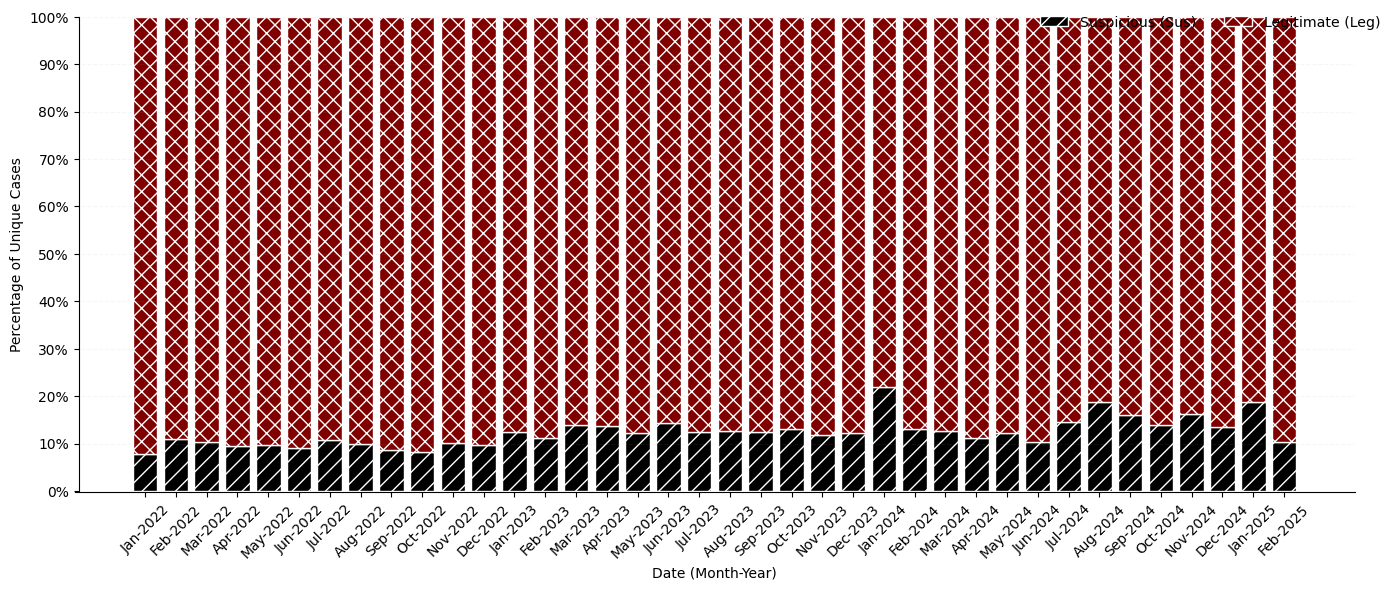

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the directory containing the CSV files
data_directory = "/dfoh_cases"

# List all CSV files in the directory
csv_files = [os.path.join(data_directory, file) for file in os.listdir(data_directory) if file.endswith(".csv")]

# Read and concatenate all CSV files into a single DataFrame
df_list = [pd.read_csv(file) for file in csv_files]
cdf_data = pd.concat(df_list, ignore_index=True)

# Convert 'date' column to datetime format
cdf_data['date'] = pd.to_datetime(cdf_data['date'], errors='coerce')

# Drop NaN dates (if any exist due to parsing errors)
cdf_data = cdf_data.dropna(subset=['date'])

# Remove redundant "sus" and "leg" values per attacker or victim
unique_sus = cdf_data[cdf_data['status'] == 'sus'].drop_duplicates(subset=['attacker', 'victim'])
unique_leg = cdf_data[cdf_data['status'] == 'leg'].drop_duplicates(subset=['attacker', 'victim'])

# Extract "Month-Year" for aggregation
unique_sus['month_year'] = unique_sus['date'].dt.strftime('%Y-%m')
unique_leg['month_year'] = unique_leg['date'].dt.strftime('%Y-%m')

# Count unique occurrences per month
sus_counts = unique_sus.groupby('month_year').size().reset_index(name='unique_sus')
leg_counts = unique_leg.groupby('month_year').size().reset_index(name='unique_leg')

# Merge both counts into one DataFrame for plotting
monthly_counts = pd.merge(sus_counts, leg_counts, on='month_year', how='outer').fillna(0)

# Sort by date to ensure bars are in chronological order
monthly_counts['month_year'] = pd.to_datetime(monthly_counts['month_year'], format='%Y-%m')
monthly_counts = monthly_counts.sort_values('month_year')

# Convert back to string for x-axis labels
monthly_counts['month_year'] = monthly_counts['month_year'].dt.strftime('%b-%Y')

# Compute total occurrences per month
monthly_counts['total'] = monthly_counts['unique_sus'] + monthly_counts['unique_leg']

# Compute percentages
monthly_counts['sus_percentage'] = (monthly_counts['unique_sus'] / monthly_counts['total']) * 100
monthly_counts['leg_percentage'] = (monthly_counts['unique_leg'] / monthly_counts['total']) * 100

# Plot stacked bar chart with percentages
plt.figure(figsize=(14, 6))

bars1 = plt.bar(
    monthly_counts['month_year'],
    monthly_counts['sus_percentage'],
    color='#000000',
    label="Suspicious (Sus)",
    hatch='//',
    edgecolor='white',
    alpha=1
)

bars2 = plt.bar(
    monthly_counts['month_year'],
    monthly_counts['leg_percentage'],
    bottom=monthly_counts['sus_percentage'],
    color='maroon',
    label="Legitimate (Leg)",
    hatch='xx',
    edgecolor='white',
    alpha=1
)

# Labels and title
plt.xlabel("Date (Month-Year)")
plt.ylabel("Percentage of Unique Cases")
# plt.title("Monthly Unique Suspicious vs. Legitimate Cases (Stacked, %)")
plt.legend(loc="upper right", bbox_to_anchor=(1.030, 1.03), ncol=4, frameon=False, fontsize=10.2)
plt.ylim(0, 100)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_position(('outward', -3))
plt.gca().spines['bottom'].set_position(('outward', 1))
plt.xticks(rotation=45)
plt.yticks(range(0, 110, 10), [f"{x}%" for x in range(0, 110, 10)])  # Show y-axis in percentage format
plt.ylim(0, 100)  # Ensure y-axis goes from 0 to 100%
plt.grid(axis='y', linestyle='--', alpha=0.1)

# Show the plot
plt.tight_layout()
plt.show()


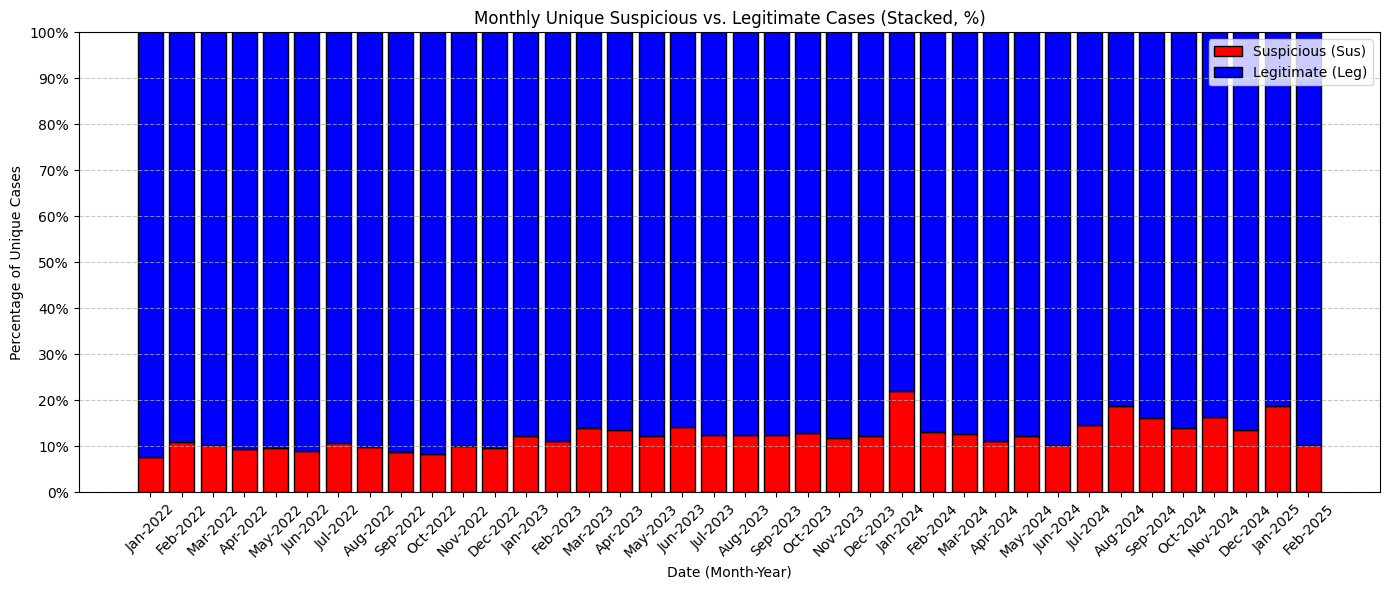

In [156]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the directory containing the CSV files
data_directory = "/home/savymik/Pictures/dfoh_cases"

# List all CSV files in the directory
csv_files = [os.path.join(data_directory, file) for file in os.listdir(data_directory) if file.endswith(".csv")]

# Read and concatenate all CSV files into a single DataFrame
df_list = [pd.read_csv(file) for file in csv_files]
cdf_data = pd.concat(df_list, ignore_index=True)

# Convert 'date' column to datetime format
cdf_data['date'] = pd.to_datetime(cdf_data['date'], errors='coerce')

# Drop NaN dates (if any exist due to parsing errors)
cdf_data = cdf_data.dropna(subset=['date'])

# Remove redundant "sus" and "leg" values per attacker or victim
unique_sus = cdf_data[cdf_data['status'] == 'sus'].drop_duplicates(subset=['attacker', 'victim'])
unique_leg = cdf_data[cdf_data['status'] == 'leg'].drop_duplicates(subset=['attacker', 'victim'])

# Extract "Month-Year" for aggregation
unique_sus['month_year'] = unique_sus['date'].dt.strftime('%Y-%m')
unique_leg['month_year'] = unique_leg['date'].dt.strftime('%Y-%m')

# Count unique occurrences per month
sus_counts = unique_sus.groupby('month_year').size().reset_index(name='unique_sus')
leg_counts = unique_leg.groupby('month_year').size().reset_index(name='unique_leg')

# Merge both counts into one DataFrame for plotting
monthly_counts = pd.merge(sus_counts, leg_counts, on='month_year', how='outer').fillna(0)

# Sort by date to ensure bars are in chronological order
monthly_counts['month_year'] = pd.to_datetime(monthly_counts['month_year'], format='%Y-%m')
monthly_counts = monthly_counts.sort_values('month_year')

# Convert back to string for x-axis labels
monthly_counts['month_year'] = monthly_counts['month_year'].dt.strftime('%b-%Y')

# Compute total occurrences per month
monthly_counts['total'] = monthly_counts['unique_sus'] + monthly_counts['unique_leg']

# Compute percentages
monthly_counts['sus_percentage'] = (monthly_counts['unique_sus'] / monthly_counts['total']) * 100
monthly_counts['leg_percentage'] = (monthly_counts['unique_leg'] / monthly_counts['total']) * 100

# Plot stacked bar chart (No Hatches)
plt.figure(figsize=(14, 6))

bars1 = plt.bar(
    monthly_counts['month_year'],
    monthly_counts['sus_percentage'],
    color='red',
    label="Suspicious (Sus)",
    edgecolor='black'
)

bars2 = plt.bar(
    monthly_counts['month_year'],
    monthly_counts['leg_percentage'],
    bottom=monthly_counts['sus_percentage'],
    color='blue',
    label="Legitimate (Leg)",
    edgecolor='black'
)

# Labels and title
plt.xlabel("Date (Month-Year)")
plt.ylabel("Percentage of Unique Cases")
plt.title("Monthly Unique Suspicious vs. Legitimate Cases (Stacked, %)")
plt.legend()
plt.xticks(rotation=45)
plt.yticks(range(0, 110, 10), [f"{x}%" for x in range(0, 110, 10)])  # Show y-axis in percentage format
plt.ylim(0, 100)  # Ensure y-axis goes from 0 to 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


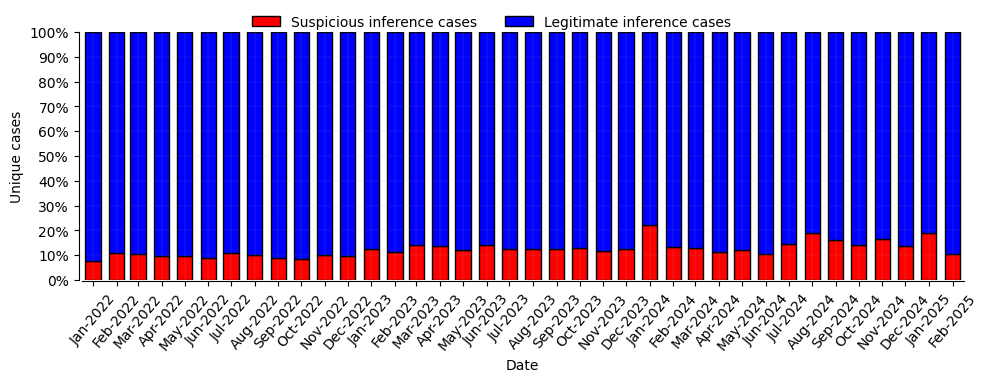

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the directory containing the CSV files
data_directory = "/home/savymik/Pictures/dfoh_cases"

# List all CSV files in the directory
csv_files = [os.path.join(data_directory, file) for file in os.listdir(data_directory) if file.endswith(".csv")]

# Read and concatenate all CSV files into a single DataFrame
df_list = [pd.read_csv(file) for file in csv_files]
cdf_data = pd.concat(df_list, ignore_index=True)

# Convert 'date' column to datetime format
cdf_data['date'] = pd.to_datetime(cdf_data['date'], errors='coerce')

# Drop NaN dates (if any exist due to parsing errors)
cdf_data = cdf_data.dropna(subset=['date'])

# Remove redundant "sus" and "leg" values per attacker or victim
unique_sus = cdf_data[cdf_data['status'] == 'sus'].drop_duplicates(subset=['attacker', 'victim'])
unique_leg = cdf_data[cdf_data['status'] == 'leg'].drop_duplicates(subset=['attacker', 'victim'])

# Extract "Month-Year" for aggregation
unique_sus['month_year'] = unique_sus['date'].dt.to_period('M')
unique_leg['month_year'] = unique_leg['date'].dt.to_period('M')

# Count unique occurrences per month
sus_counts = unique_sus.groupby('month_year').size().reset_index(name='unique_sus')
leg_counts = unique_leg.groupby('month_year').size().reset_index(name='unique_leg')

# Merge both counts into one DataFrame for plotting
monthly_counts = pd.merge(sus_counts, leg_counts, on='month_year', how='outer').fillna(0)

# Convert back to datetime for sorting and plotting
monthly_counts['month_year'] = monthly_counts['month_year'].dt.to_timestamp()
monthly_counts = monthly_counts.sort_values('month_year')

# Compute total occurrences per month
monthly_counts['total'] = monthly_counts['unique_sus'] + monthly_counts['unique_leg']

# Compute percentages
monthly_counts['sus_percentage'] = (monthly_counts['unique_sus'] / monthly_counts['total']) * 100
monthly_counts['leg_percentage'] = (monthly_counts['unique_leg'] / monthly_counts['total']) * 100

# Plot stacked bar chart (No Hatches)
plt.figure(figsize=(10, 4))

bars1 = plt.bar(
    monthly_counts['month_year'],
    monthly_counts['sus_percentage'],
    color='red',
    label="Suspicious inference cases",
    edgecolor='black',
    width=20  # Adjust bar width to avoid overlap
)

bars2 = plt.bar(
    monthly_counts['month_year'],
    monthly_counts['leg_percentage'],
    bottom=monthly_counts['sus_percentage'],
    color='blue',
    label="Legitimate inference cases",
    edgecolor='black',
    width=20
)

# Labels and title
plt.xlabel("Date")
plt.ylabel("Unique cases")
# plt.title("Monthly Unique Suspicious vs. Legitimate Cases (Stacked, %)")
plt.legend()
plt.xticks(monthly_counts['month_year'], monthly_counts['month_year'].dt.strftime('%b-%Y'), rotation=45)
plt.yticks(range(0, 110, 10), [f"{x}%" for x in range(0, 110, 10)])  # Show y-axis in percentage format
plt.ylim(0, 100)  # Ensure y-axis goes from 0 to 100%

# Fix x-axis limits
plt.xlim(monthly_counts['month_year'].min() - pd.Timedelta(days=15), 
         monthly_counts['month_year'].max() + pd.Timedelta(days=15))

# Fix white space by removing margins
plt.margins(x=0)

# Grid and layout improvements
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc="upper right", bbox_to_anchor=(0.75, 1.12), ncol=2, frameon=False, fontsize=10)
plt.grid(linestyle='--', linewidth=0.15)
plt.ylim(0, 100)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_position(('outward', 2))
plt.gca().spines['bottom'].set_position(('outward', 1))
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


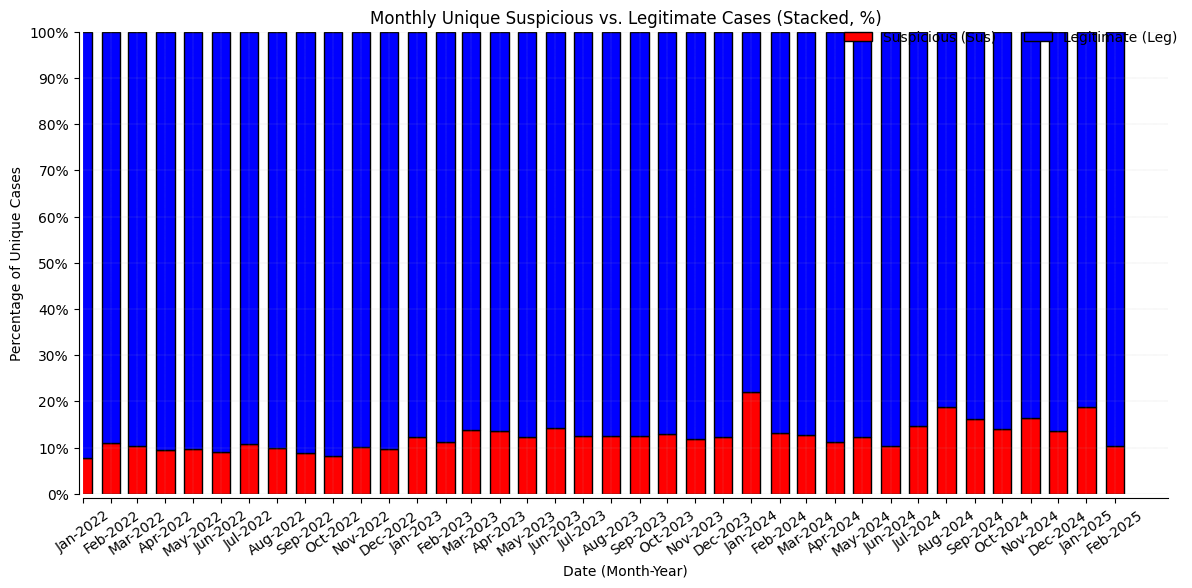

In [220]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the directory containing the CSV files
data_directory = "/home/savymik/Pictures/dfoh_cases"

# List all CSV files in the directory
csv_files = [os.path.join(data_directory, file) for file in os.listdir(data_directory) if file.endswith(".csv")]

# Read and concatenate all CSV files into a single DataFrame
df_list = [pd.read_csv(file) for file in csv_files]
cdf_data = pd.concat(df_list, ignore_index=True)

# Convert 'date' column to datetime format
cdf_data['date'] = pd.to_datetime(cdf_data['date'], errors='coerce')

# Drop NaN dates (if any exist due to parsing errors)
cdf_data = cdf_data.dropna(subset=['date'])

# Remove redundant "sus" and "leg" values per attacker or victim
unique_sus = cdf_data[cdf_data['status'] == 'sus'].drop_duplicates(subset=['attacker', 'victim'])
unique_leg = cdf_data[cdf_data['status'] == 'leg'].drop_duplicates(subset=['attacker', 'victim'])

# Extract "Month-Year" for aggregation
unique_sus['month_year'] = unique_sus['date'].dt.to_period('M')
unique_leg['month_year'] = unique_leg['date'].dt.to_period('M')

# Count unique occurrences per month
sus_counts = unique_sus.groupby('month_year').size().reset_index(name='unique_sus')
leg_counts = unique_leg.groupby('month_year').size().reset_index(name='unique_leg')

# Merge both counts into one DataFrame for plotting
monthly_counts = pd.merge(sus_counts, leg_counts, on='month_year', how='outer').fillna(0)

# Convert back to datetime for sorting and plotting
monthly_counts['month_year'] = monthly_counts['month_year'].dt.to_timestamp()
monthly_counts = monthly_counts.sort_values('month_year')

# Compute total occurrences per month
monthly_counts['total'] = monthly_counts['unique_sus'] + monthly_counts['unique_leg']

# Compute percentages
monthly_counts['sus_percentage'] = (monthly_counts['unique_sus'] / monthly_counts['total']) * 100
monthly_counts['leg_percentage'] = (monthly_counts['unique_leg'] / monthly_counts['total']) * 100

# Convert x-axis limits to datetime
x_min = pd.Timestamp("2022-01-01")  # January 2022
x_max = pd.Timestamp("2025-03-31")  # April 2025

# Plot stacked bar chart (No Hatches)
plt.figure(figsize=(14, 6))

bars1 = plt.bar(
    monthly_counts['month_year'],
    monthly_counts['sus_percentage'],
    color='red',
    label="Suspicious (Sus)",
    edgecolor='black',
    width=20
)

bars2 = plt.bar(
    monthly_counts['month_year'],
    monthly_counts['leg_percentage'],
    bottom=monthly_counts['sus_percentage'],
    color='blue',
    label="Legitimate (Leg)",
    edgecolor='black',
    width=20
)

# Labels and title
plt.xlabel("Date (Month-Year)")
plt.ylabel("Percentage of Unique Cases")
plt.title("Monthly Unique Suspicious vs. Legitimate Cases (Stacked, %)")
plt.legend()
plt.xticks(monthly_counts['month_year'], monthly_counts['month_year'].dt.strftime('%b-%Y'), rotation=45)
plt.yticks(range(0, 110, 10), [f"{x}%" for x in range(0, 110, 10)])  # Show y-axis in percentage format
plt.ylim(0, 100)  # Ensure y-axis goes from 0 to 100%

# Explicitly set x-axis limits
plt.xlim(x_min, x_max)

# Fix white space by removing margins
plt.margins(x=1)

plt.legend(loc="upper right", bbox_to_anchor=(1.020, 1.03), ncol=2, frameon=False, fontsize=10)
plt.grid(linestyle='--', linewidth=0.15)
plt.ylim(0, 100)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_position(('outward', 3))
plt.gca().spines['bottom'].set_position(('outward', 3))
plt.xticks(rotation=35)

# Show the plot
plt.show()


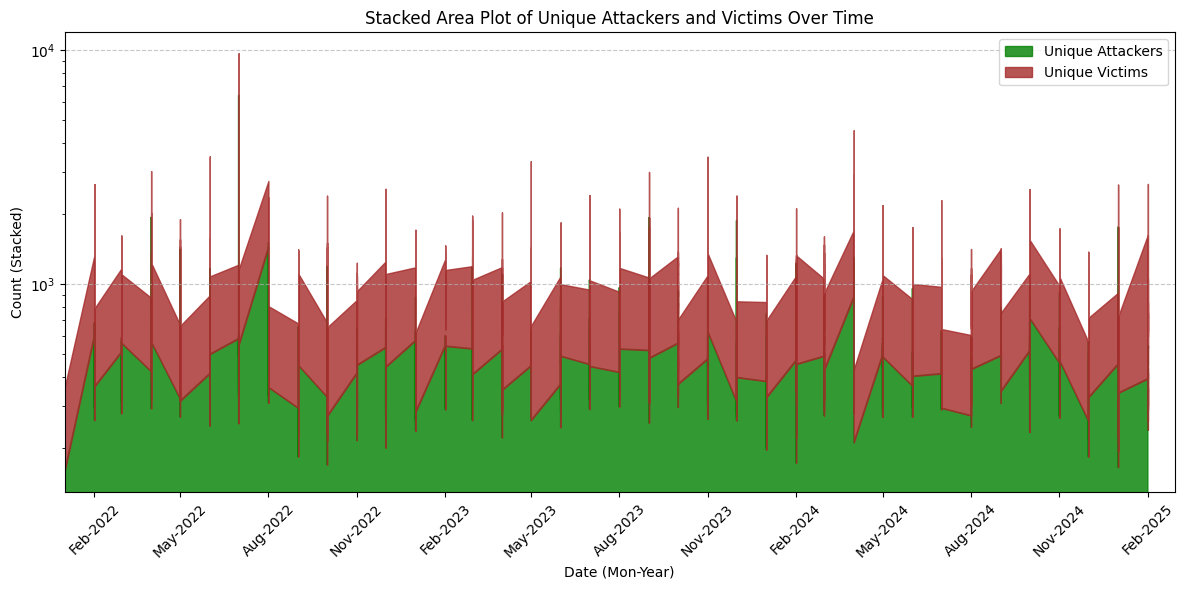

In [77]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))

# Stack attackers at the bottom
plt.fill_between(cdf_data['date'], cdf_data['unique_attackers'], color='green', alpha=0.8, label="Unique Attackers")

# Stack victims on top of attackers
plt.fill_between(cdf_data['date'], cdf_data['unique_attackers'] + cdf_data['unique_victims'], 
                 cdf_data['unique_attackers'], color='brown', alpha=0.8, label="Unique Victims")

# Format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months
plt.xlim([start_date, end_date])

# Labels and title
plt.xlabel("Date (Mon-Year)")
plt.ylabel("Count (Stacked)")
plt.title("Stacked Area Plot of Unique Attackers and Victims Over Time")
plt.legend()
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)
plt.yscale("log")  # Makes spikes less extreme

# Show the plot
plt.tight_layout()
plt.show()


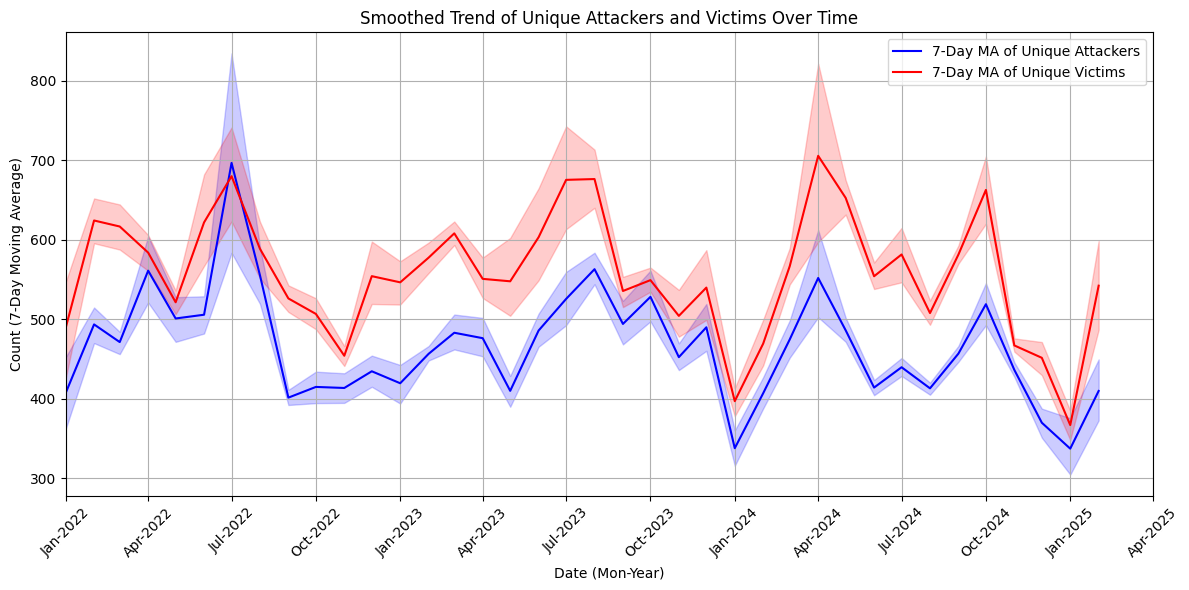

In [37]:
cdf_data['attackers_ma'] = cdf_data['unique_attackers'].rolling(window=7, min_periods=1).mean()
cdf_data['victims_ma'] = cdf_data['unique_victims'].rolling(window=7, min_periods=1).mean()

plt.figure(figsize=(12, 6))
sns.lineplot(data=cdf_data, x='date', y='attackers_ma', label="7-Day MA of Unique Attackers", color='blue')
sns.lineplot(data=cdf_data, x='date', y='victims_ma', label="7-Day MA of Unique Victims", color='red')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  
plt.xlim([start_date, end_date])

plt.xlabel("Date (Mon-Year)")
plt.ylabel("Count (7-Day Moving Average)")
plt.title("Smoothed Trend of Unique Attackers and Victims Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


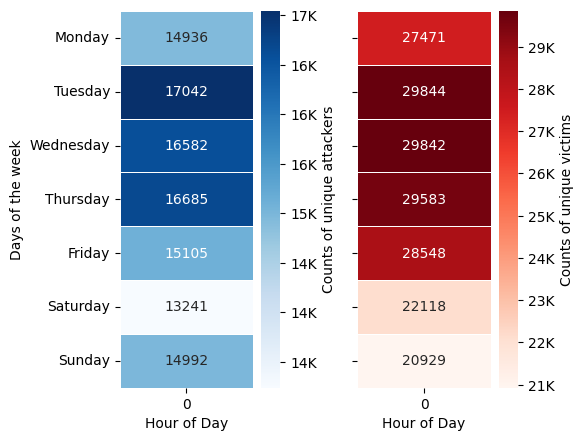

In [74]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Define the function for formatting large numbers
def format_large(value, _):
    if value >= 1e9:
        return f"{value/1e9:.1f}B"
    elif value >= 1e6:
        return f"{value/1e6:.1f}M"
    elif value >= 1e3:
        return f"{value/1e3:.0f}K"
    return f"{value:.0f}"

# Extract hour and day-of-week from the date column
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.day_name()

# Sort the days in correct order
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Compute unique attackers and victims per hour-day combination
heatmap_data = df.groupby(['day_of_week', 'hour']).agg(
    unique_attackers=('attacker', 'nunique'),
    unique_victims=('victim', 'nunique')
).reset_index()

# Create pivot tables for unique attackers and victims
attackers_pivot = heatmap_data.pivot(index='day_of_week', columns='hour', values='unique_attackers').fillna(0)
victims_pivot = heatmap_data.pivot(index='day_of_week', columns='hour', values='unique_victims').fillna(0)

# Ensure correct day order
attackers_pivot = attackers_pivot.reindex(day_order)
victims_pivot = victims_pivot.reindex(day_order)

# Create figure with two side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(6, 4.5), sharey=True)

# Unique Attackers Heatmap (Left)
ax1 = sns.heatmap(attackers_pivot, cmap="Blues", annot=True, fmt="d", linewidths=0.5, ax=axes[0], 
                   cbar_kws={'format': ticker.FuncFormatter(format_large), 'label': "Counts of unique attackers"})
# axes[0].set_title("Unique Attackers")
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Days of the week")

# Unique Victims Heatmap (Right)
ax2 = sns.heatmap(victims_pivot, cmap="Reds", annot=True, fmt="d", linewidths=0.5, ax=axes[1], 
                   cbar_kws={'format': ticker.FuncFormatter(format_large), 'label': "Counts of unique victims"})
# axes[1].set_title("Unique Victims")
axes[1].set_xlabel("Hour of Day")
axes[1].set_ylabel("")

# Adjust layout and spacing
plt.subplots_adjust(wspace=5)  # Adjust space between heatmaps (increase for more space)

plt.tight_layout()
plt.show()


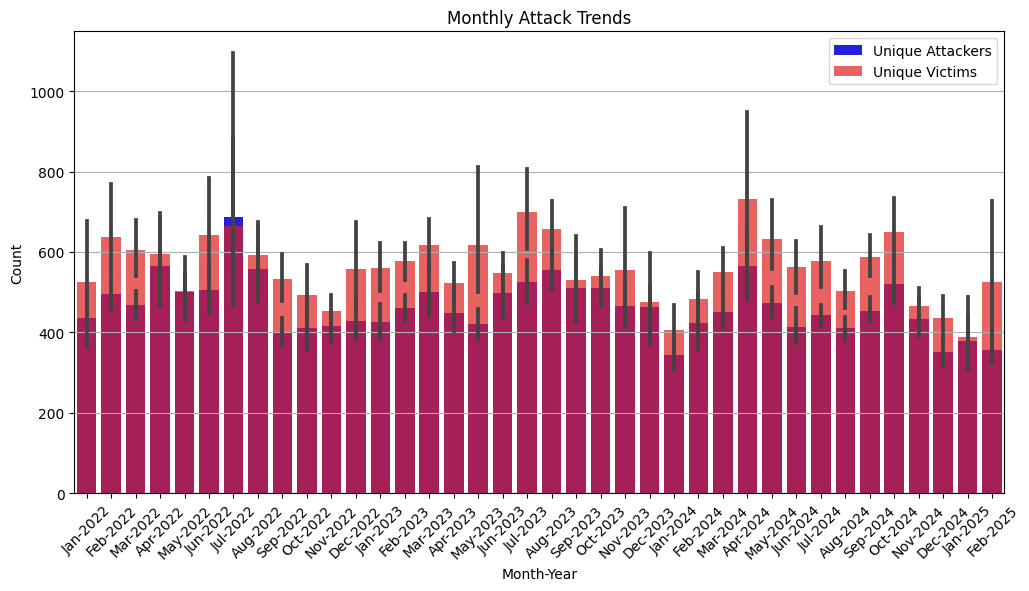

In [41]:
cdf_data['month_year'] = cdf_data['date'].dt.strftime('%b-%Y')

plt.figure(figsize=(12, 6))
sns.barplot(data=cdf_data, x='month_year', y='unique_attackers', color='blue', label="Unique Attackers")
sns.barplot(data=cdf_data, x='month_year', y='unique_victims', color='red', alpha=0.7, label="Unique Victims")

plt.xticks(rotation=45)
plt.xlabel("Month-Year")
plt.ylabel("Count")
plt.title("Monthly Attack Trends")
plt.legend()
plt.grid(axis='y')
plt.show()


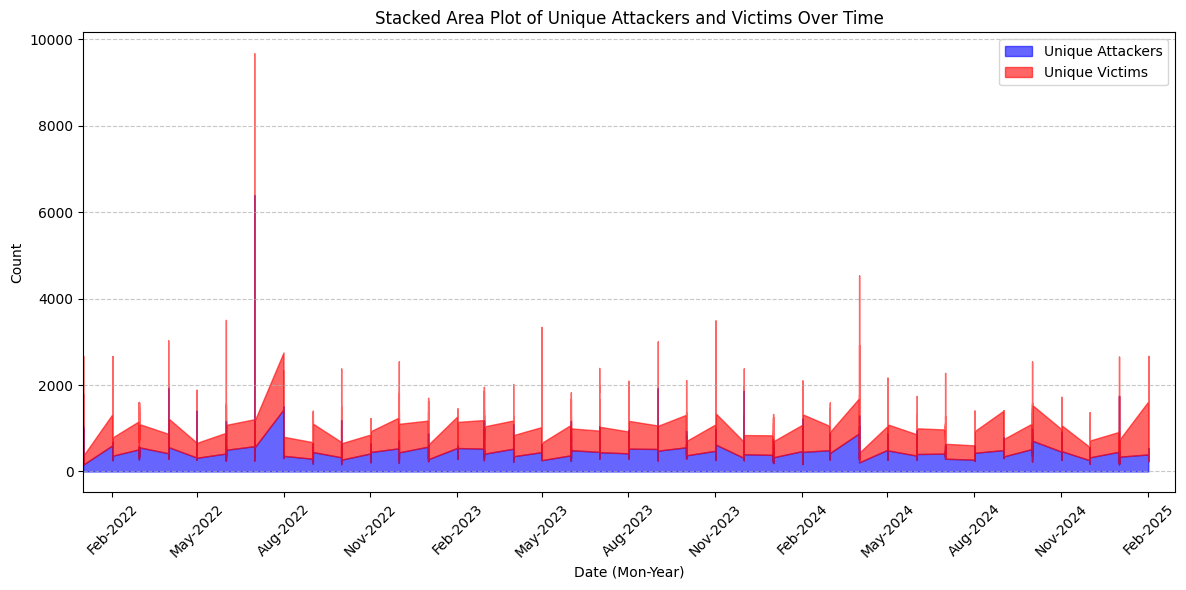

In [43]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure the date is formatted correctly
cdf_data['month_year'] = pd.to_datetime(cdf_data['date']).dt.strftime('%b-%Y')

# Sort data by date
cdf_data = cdf_data.sort_values('date')

# Define explicit x-axis limits
start_date = pd.to_datetime("2022-01-01")
end_date = pd.to_datetime("2025-03-01")

# Create the figure
plt.figure(figsize=(12, 6))

# Plot the stacked area chart
plt.fill_between(cdf_data['date'], cdf_data['unique_attackers'], color='blue', alpha=0.6, label="Unique Attackers")
plt.fill_between(cdf_data['date'], cdf_data['unique_victims'] + cdf_data['unique_attackers'], 
                 cdf_data['unique_attackers'], color='red', alpha=0.6, label="Unique Victims")

# Set x-axis format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months

# Explicitly set x-axis limits
plt.xlim([start_date, end_date])

# Labels and title
plt.xlabel("Date (Mon-Year)")
plt.ylabel("Count")
plt.title("Stacked Area Plot of Unique Attackers and Victims Over Time")
plt.legend()
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


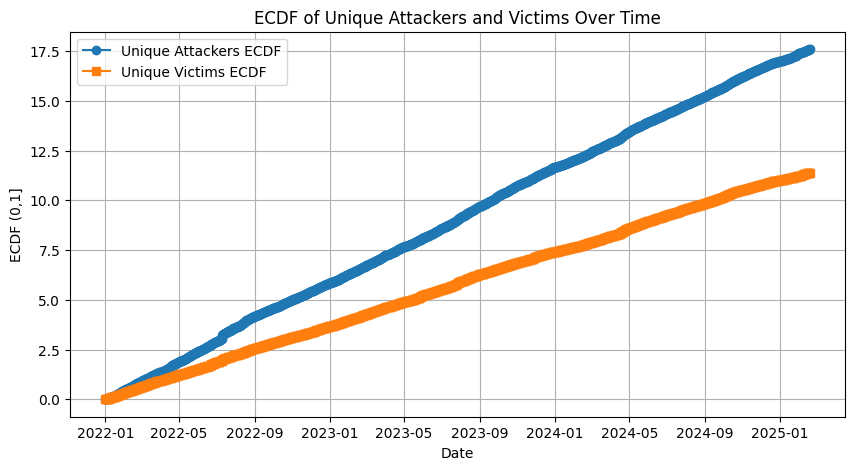

In [4]:
# Recompute ECDF for unique attackers and victims

# Convert counts to ECDF values
total_attackers = len(set().union(*unique_attackers.values()))
total_victims = len(set().union(*unique_victims.values()))

attackers_ecdf = np.cumsum([len(unique_attackers[date]) for date in dates]) / total_attackers
victims_ecdf = np.cumsum([len(unique_victims[date]) for date in dates]) / total_victims

# Plot ECDF
plt.figure(figsize=(10, 5))
plt.plot(dates, attackers_ecdf, label="Unique Attackers ECDF", marker='o')
plt.plot(dates, victims_ecdf, label="Unique Victims ECDF", marker='s')
plt.xlabel("Date")
plt.ylabel("ECDF (0,1]")
plt.title("ECDF of Unique Attackers and Victims Over Time")
plt.legend()
plt.grid()

# Show the plot
plt.show()
